A notebook to try fitting FA models with variational inference

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch

from janelia_core.ml.extra_torch_modules import ConstantBoundedFcn
from janelia_core.ml.torch_distributions import CondGaussianDistribution
from janelia_core.ml.utils import list_torch_devices
from janelia_core.visualization.utils import enforce_constant_clims

In [3]:
%matplotlib notebook

## Parameters go here

In [4]:
d = 1000000 # Number of observed variables
m = 100 # Number of latents
n = 5000 # Number of samples

use_gpu = True

## Determine if a GPU is available


In [5]:
if use_gpu:
    device, gpu_available = list_torch_devices()
    device = device[0]
else:
    device = torch.device('cpu')
    gpu_available = False

Found 1 GPUs


## Generate true model parameters

In [6]:
mu = torch.randn(d)
lam = torch.randn(d,m)
psi_diag = torch.randn(d)**2 + 1

## Generate data

In [7]:
z = torch.randn(n, m)
x = torch.matmul(z, lam.t()) + torch.randn(n,d)*torch.sqrt(psi_diag) + mu

## Fit the model with variational inference

In [8]:
# Setup the observation model P(x|z) = N(\mu + lam*z, psi)

cond_mn_f = torch.nn.Linear(in_features=m, out_features=d, bias=True)
cond_std_f = ConstantBoundedFcn(lower_bound=.001*np.ones(d), 
                                upper_bound=10*np.ones(d),
                                init_value=.1*np.ones(d))
condObsDist = CondGaussianDistribution(mn_f=cond_mn_f, std_f=cond_std_f)

In [9]:
# Setup the variational posterior

In [10]:
class FAVariationalPosterior(torch.nn.Module):
    
    def __init__(self, latent_d: int, n_smps: int):
        """ Creates a new FAVariationalPosterior object. 
        
        Args:
        
            latent_d: Latent dimensionality
            
            n_smps: The number of samples we will calculate posteriors over 
        
        """
        super().__init__()
        
        self.m = latent_d
        self.n = n_smps
        
        #self.mns = torch.nn.Parameter(torch.randn(n_smps, latent_d))
        #self.c = torch.nn.Parameter(torch.randn(latent_d, latent_d))
        self.mns = torch.nn.Parameter(torch.zeros(n_smps, latent_d))
        self.c = torch.nn.Parameter(torch.diag(torch.ones(latent_d)))
        
    def kl(self, inds):
        """ Computes KL divergence between posterior of latent state over a given set of data points and the standard normal.
        
        Args: 
        
            inds: Indices of data points we form the posterior of latent state over. 
            
        Returns:
        
            kl: The kl divergence for the posterior relative to the standard normal
        """
        
        n_kl_data_pts = len(inds)
        
        cov_m = self.c.mm(self.c.T)
        
        cov_trace_sum = n_kl_data_pts*torch.trace(cov_m) 
        m_norm_sum = torch.sum(self.mns[inds]**2)
        m_sum = n_kl_data_pts*self.m
        log_det_sum = n_kl_data_pts*torch.logdet(cov_m)
        
        return .5*(cov_trace_sum + m_norm_sum - m_sum - log_det_sum)
    
    def sample(self, inds):
        """ Samples latent values from the posterior for given data points. """
        
        cur_device = self.c.device
        
        n_data_pts = len(inds)
        
        return torch.randn(n_data_pts, self.m, device=cur_device).mm(self.c.T) + self.mns[inds,:]
        

In [11]:
posterior = FAVariationalPosterior(latent_d=m, n_smps=n)

## Fit the model

In [12]:
batch_size = 100
n_fit_its = 1000

In [13]:
if gpu_available:
    x = x.to(device)
    posterior.to(device)
    condObsDist.to(device)

In [23]:
params = list(posterior.parameters()) + list(condObsDist.parameters())
optimizer = torch.optim.Adam(params=params, lr=.01)

In [24]:
t0 = time.time()
for b_i in range(n_fit_its):
    
    optimizer.zero_grad()
    
    # Determine which data points we will fit for
    batch_smp_indices = torch.randperm(n)[0:batch_size]
    
    batch_x = x[batch_smp_indices,:]
    
    # Sample the posteriors over latents for these data points
    batch_post_smps = posterior.sample(batch_smp_indices)
    
    # Calculate the log-likelihood of the observed data given the sampled latents
    log_prob = torch.sum(condObsDist.log_prob(batch_post_smps, batch_x))
    
    # Calculate kl divergence of the posterior for the batch data points and the prior
    kl = posterior.kl(batch_smp_indices)
    
    # Calculate the final objective 
    obj = -log_prob + kl
    
    # Give user some feedback
    if b_i % 100 == 0:
        print('***** Iteration ' + str(b_i) + ' *****')
        print('LL: ' + str(log_prob.detach().cpu().numpy()))
        print('KL: ' + str(kl.detach().cpu().numpy()))
        print('Objective: ' + str(obj.detach().cpu().numpy()))
        
    obj.backward()
    optimizer.step()
    
t1 = time.time()
print('Fitting done.  Time: ' + str(t1 - t0))

***** Iteration 0 *****
LL: -249636620.0
KL: 41010.477
Objective: 249677630.0
***** Iteration 100 *****
LL: -242061540.0
KL: 39593.516
Objective: 242101140.0
***** Iteration 200 *****
LL: -238479220.0
KL: 39393.957
Objective: 238518610.0
***** Iteration 300 *****
LL: -231908900.0
KL: 39359.395
Objective: 231948260.0
***** Iteration 400 *****
LL: -222048670.0
KL: 40154.133
Objective: 222088830.0
***** Iteration 500 *****
LL: -217911680.0
KL: 40844.164
Objective: 217952530.0
***** Iteration 600 *****
LL: -212632050.0
KL: 41221.336
Objective: 212673260.0
***** Iteration 700 *****
LL: -209191520.0
KL: 41594.676
Objective: 209233120.0
***** Iteration 800 *****
LL: -203769150.0
KL: 42060.96
Objective: 203811220.0
***** Iteration 900 *****
LL: -198798720.0
KL: 41750.895
Objective: 198840460.0
Fitting done.  Time: 47.952717304229736


## Examine results of fit

In [25]:
lambda_hat = cond_mn_f.weight[0:100,:].detach().cpu()
mu_hat = cond_mn_f.bias.detach().cpu().numpy()
psi_diag_hat = cond_std_f(torch.ones(1)).detach().cpu().numpy().squeeze()**2

In [26]:
true_cov_str = lam[0:100,:].matmul(lam[0:100,:].T).numpy()
cov_str_hat = lambda_hat.matmul(lambda_hat.T).numpy()

<IPython.core.display.Javascript object>


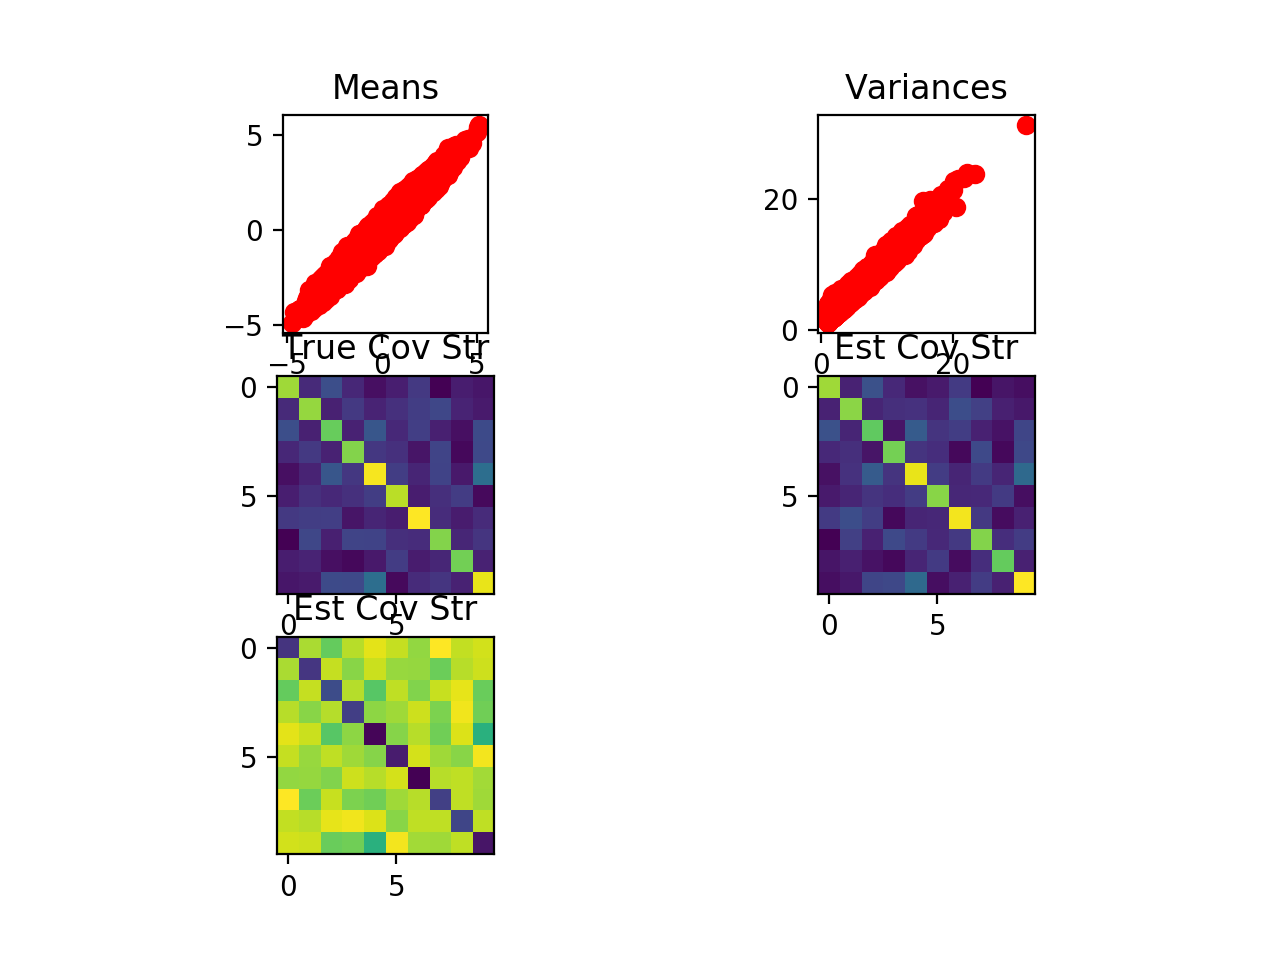

Text(0.5, 1.0, 'Est Cov Str')

In [27]:
plt.figure()

ax = plt.subplot(3,2,1)
ax.plot(mu, mu_hat, 'ro')
ax.set_aspect('equal', 'box')
plt.title('Means')

ax = plt.subplot(3,2,2)
ax.plot(psi_diag, psi_diag_hat, 'ro')
ax.set_aspect('equal', 'box')
plt.title('Variances')

ax_tc = plt.subplot(3,2,3)
im_tc = ax_tc.imshow(true_cov_str[0:10, 0:10])
plt.title('True Cov Str')

ax_ch =plt.subplot(3,2,4)
im_ch = ax_ch.imshow(cov_str_hat[0:10, 0:10])
plt.title('Est Cov Str')

ax_diff =plt.subplot(3,2,5)
im_diff = ax_diff.imshow(cov_str_hat[0:10, 0:10] - true_cov_str[0:10, 0:10])
plt.title('Est Cov Str')

#enforce_constant_clims(ims=[im_tc, im_ch, im_diff])